This notebook can be run on mybinder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fchatelaf%2Fml-sicom3a/master?urlpath=lab/tree/notebooks/5bis_linear_models_lasso_logistic/)

## Un échantillon rétrospectif d'hommes dans une région à haut risque de maladies cardiaques du Cap-Occidental, en Afrique du Sud. Il y a environ deux témoins pour chaque cas de maladie coronarienne (CHD). Beaucoup d'hommes atteints de CHD ont suivi un traitement pour réduire leur pression artérielle et d'autres programmes visant à diminuer leurs facteurs de risque après leur événement cardiaque. Dans certains cas, les mesures ont été effectuées après ces traitements. Ces données sont issues d'un ensemble plus vaste, décrit dans Rousseauw et al., 1983, South African Medical Journal.

Nom de la variable	Description
sbp:	Pression artérielle systolique
tobacco:	Consommation cumulée de tabac (kg)
ldl:	Lipoprotéines de basse densité (cholestérol)
adiposity:	Adiposité
famhist:	Antécédents familiaux de maladies cardiaques (Présent=1, Absent=0)
typea:	Comportement de type A
obesity:	Obésité
alcohol:	Consommation actuelle d'alcool
age:	Âge au moment de l'apparition de la maladie
chd	Réponse : maladie coronarienne (Présente=1, Absente=0)

#### Load the data set

In [2]:
import pandas as pd
import numpy as np

# load data set
heart = pd.read_csv("SAheart.csv", sep=",", header=0)
heart.head()  # data overview: variable names and first values

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


#### Display some summary statistics

In [3]:
heart.describe()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,231.935065,138.326840,3.635649,4.740325,25.406732,0.415584,53.103896,26.044113,17.044394,42.816017,0.346320
std,133.938585,20.496317,4.593024,2.070909,7.780699,0.493357,9.817534,4.213680,24.481059,14.608956,0.476313
min,1.000000,101.000000,0.000000,0.980000,6.740000,0.000000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,116.250000,124.000000,0.052500,3.282500,19.775000,0.000000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,231.500000,134.000000,2.000000,4.340000,26.115000,0.000000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,347.750000,148.000000,5.500000,5.790000,31.227500,1.000000,60.000000,28.497500,23.892500,55.000000,1.000000
max,463.000000,218.000000,31.200000,15.330000,42.490000,1.000000,78.000000,46.580000,147.190000,64.000000,1.000000


#### Format the input/target data set

In [4]:
y = np.asarray(heart.iloc[:, 10], "float")
X = np.asarray(heart.iloc[:, 1:10], "float")
names = list(heart.columns[1:10])  # variable names
y = heart.iloc[:, 10]
X = heart.iloc[:, 1:10]

# Data matrix X is (n,p) where p is the number of variable and n the number of sample
(n, p) = X.shape
ncases = int(np.sum(y))  # number of cases
print("On a {} échantillons: dont cas {}  et control {:d}".format(n, ncases, n - ncases))

On a 462 échantillons: dont cas 160  et control 302


## Compute ordinary (without regularization) Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from time import time


sc = StandardScaler()
X = heart.iloc[:, 1:10]
Xs = sc.fit_transform(X)

print("Optimisation ...")
start = time()
clf = LogisticRegression(penalty=None, tol=1e-6, max_iter=int(1e6))
clf.fit(Xs, y)
print("temps d'éxecution" % (time() - start))
betas = pd.DataFrame.from_records(clf.coef_, columns=names, index=["Weights"])
betas["intercept"] = clf.intercept_
print("Estimated Weights for standardized variables:\n")
betas.head()

Computing LR estimates ...
This took 0.006s
Estimated Weights for standardized variables:



,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,intercept
Weights,0.133165,0.364183,0.35979,0.144461,0.456041,0.388302,-0.264797,0.002973,0.659983,-0.878548


**Exercice**:
Que signifie un poids positif, négatif ou proche de zéro pour prédire une maladie cardiaque ?
Comment interprétez-vous le poids de l'obésité, par exemple ?
Comment expliquez-vous de tels résultats surprenants ?


## Par exemple, pour une régression logistique avec une régularisation de type Lasso (pénalité $\ell_1$), on obtient, pour une classification binaire où $y_i \in {-1,+1}$, le problème d’optimisation suivant :
$$
\min_{\beta}   \sum_{i=1}^n \log(\exp(- y_i (X_i^T \beta )) + 1) +  \lambda \| \beta \|_1.$$

In [6]:
# compute lasso path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from time import time
from sklearn.svm import l1_min_c

import matplotlib.pyplot as plt

# Normaliser les données est important
sc = StandardScaler()
Xs = sc.fit_transform(X)  # center  (zero mean) and reduce (unit variance) the variables
Xs = pd.DataFrame.from_records(Xs, columns=names)


cs = l1_min_c(Xs, y, loss="log") * np.logspace(0, 4, 30)


print("Computing regularization path ...")
start = time()
clf = LogisticRegression(
    penalty="l1", solver="saga", tol=1e-6, max_iter=int(1e6), warm_start=True
)
coefs_ = []
beta_l1norm = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(Xs, y)
    beta_l1norm.append(np.sum(np.abs(clf.coef_.ravel())))
    coefs_.append(clf.coef_.ravel().copy())
print("Temps %0.3fs" % (time() - start))

betas = np.array(coefs_)

Computing regularization path ...
Temps 0.126s


In [32]:
l1_min_c(Xs, y, loss="log")

np.float64(0.012197160838705283)

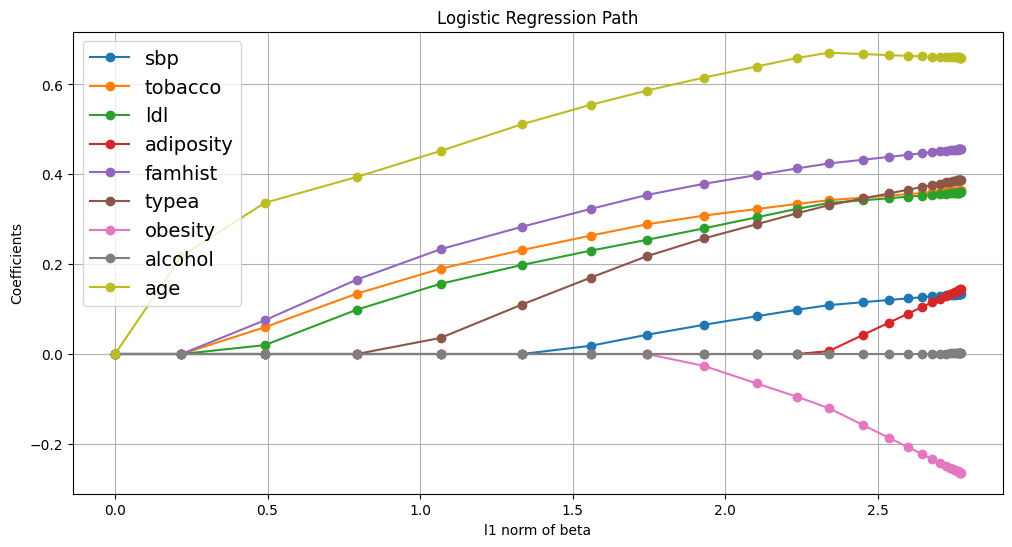

In [9]:
plt.figure(figsize=(12, 6))
#plt.plot(np.log10(cs), coefs_, marker='o')
plt.plot(beta_l1norm, betas, marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("l1 norm of beta")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Path")
plt.axis("tight")
plt.legend(names, fontsize=14)
plt.grid("On")
plt.show()

In [12]:
from sklearn.linear_model import LogisticRegressionCV

print("Computing K-fold CV ...")
# K fold cross validation  (K=5)
start = time()
cs = l1_min_c(Xs, y, loss="log") * np.logspace(
    0, 2, 50
)  # the vector fot the alpha (lasso penalty parameter) values
model = LogisticRegressionCV(Cs=cs, cv=5, penalty="l1", solver="saga", tol=1e-6).fit(
    Xs, y
)
print("Temps %0.3fs" % (time() - start))

Computing K-fold CV ...
Temps 0.524s


In [13]:
# Now model is tuned with the penalty parameter estimated by CV
lambda_cv = model.C_[0]
# The coef estimated with CV
beta_l1norm = np.sum(np.abs(model.coef_))

print("CV estimates:")
print(
    "- lambda = {:.3f}, which yields ||beta||_1 = {:.3f}\n".format(
        lambda_cv, beta_l1norm
    )
)
print("CV weights for standardized variables:")
betas_cv = pd.DataFrame.from_records(model.coef_, columns=names, index=["Weights"])
betas_cv["intercept"] = model.intercept_
betas_cv.head()

CV estimates:
- lambda = 0.060, which yields ||beta||_1 = 1.342

CV weights for standardized variables:


,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,intercept
Weights,0.0,0.232516,0.199362,0.0,0.284652,0.112161,0.0,0.0,0.513102,-0.745617


### Exercice
- What are the only significant variables estimated with cross-validation? 
- How can we rank them by significance order (*hint: look at the lasso path*)?
- Do these results seem more credible (than those obtain without regularization) to predict heart diseases? 

### Calculer la probabilité de CHD pour quelques patients

Pour ce type de problème, nous nous intéressons davantage à la modélisation des relations entre les variables explicatives et la variable réponse, ainsi qu'à leur interprétation, plutôt qu'à la simple prédiction des réponses binaires (présence ou absence de CHD). Avec un modèle linéaire généralisé tel que la régression logistique, il est possible de calculer une probabilité de risque pour chaque patient et d'évaluer l'influence de chaque variable de manière interprétable.

In [28]:
# Get the predicted risk for the first patient
ipatient = 10 # patient index
x = Xs.loc[ipatient:ipatient, :]  # x is a dataframe with column names

ylabel = "Case" if y[ipatient] else "Control"
print("**{}** patient with (standardized) features:\n{}\n".format(ylabel, x))

# TODO: augmenter/dimuner la consommation du tabac
x_copy = x.copy()
x_copy["tobacco"] += 1

# Proba of heart disease
proba_CHD_0 = model.predict_proba(x)[0, 1]
proba_CHD = model.predict_proba(x_copy)[0, 1]
print("Proba (CHD) sans ajout consommation: {:.3f}".format(proba_CHD_0))
print("Proba (CHD) après ajout consommation: {:.3f}".format(proba_CHD))

**Case** patient with (standardized) features:
         sbp   tobacco       ldl  adiposity   famhist     typea   obesity  \
10  3.305302  0.515328 -0.865449   0.883045 -0.843274  1.926817  0.181959   

     alcohol       age  
10  1.595433  1.177539  

Proba (CHD) sans ajout consommation: 0.446
Proba (CHD) après ajout consommation: 0.504


In [31]:
w_tobacco = betas_cv["tobacco"].to_numpy()[0] 
print("poids estimé pour : {:.2f}".format(w_tobacco))
# Calcul des cotes (odds) avant et après modification
odds_0 = proba_CHD_0 / (1 - proba_CHD_0)
odds = proba_CHD / (1 - proba_CHD)
print("Augmentation de risque quand la consommation augmente de 1 {:.2f}".format(np.log(odds/odds_0)) )

poids estimé pour : 0.23
Augmentation de risque quand la consommation augmente de 1 0.23
